# **Identification Dysarthria Classification**

This Notebook created for the SIF(Singapore International Foundation) project AI learning program.

About The Project:


> Dysarthria is a speech disorder caused by motor abnormalities. It is caused by damage or abnormalities in the motor system that controls the parts of the body involved in the speech process, such as the jaw, voice box and tongue. Dysarthria can occur at any age, from children to adults. 


About The Data: 
- The data was downloaded from [Public Domain Dataset Kaggle ](https://www.kaggle.com/datasets/poojag718/dysarthria-and-nondysarthria-speech-dataset?select=data_with_path.csv)
- It's contain's Audio Dataset which only record adult Female and Male who have identification as have dysarthria symptoms and Not have dysarthria symptoms.

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import os
import re
import warnings
#Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Audio Libraries
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

#Convolutional Neural Network Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Resizing

warnings.filterwarnings("ignore")

# Loading Data

In [2]:
dir='dysarthria-detection'
data=pd.read_csv('dysarthria-detection/data.csv')

In [3]:
# Joining The Data and The Audio File
def add_directory_to_filename(filename, directory):
    return os.path.join(directory, filename)

data['filename']=data['filename'].apply(add_directory_to_filename,directory=dir)
data

,is_dysarthria,gender,filename
0,non_dysarthria,female,dysarthria-detection/torgo_data/non_dysarthria...
1,non_dysarthria,female,dysarthria-detection/torgo_data/non_dysarthria...
2,non_dysarthria,female,dysarthria-detection/torgo_data/non_dysarthria...
3,non_dysarthria,female,dysarthria-detection/torgo_data/non_dysarthria...
4,non_dysarthria,female,dysarthria-detection/torgo_data/non_dysarthria...
...,...,...,...
1995,dysarthria,male,dysarthria-detection/torgo_data/dysarthria_mal...
1996,dysarthria,male,dysarthria-detection/torgo_data/dysarthria_mal...
1997,dysarthria,male,dysarthria-detection/torgo_data/dysarthria_mal...
1998,dysarthria,male,dysarthria-detection/torgo_data/dysarthria_mal...


In [4]:
#Counting Value of the target
data['is_dysarthria'].value_counts()

is_dysarthria
non_dysarthria    1000
dysarthria        1000
Name: count, dtype: int64

In [5]:
#Counting Based on Gander
data.groupby(['gender', 'is_dysarthria']).size().reset_index(name='count')

,gender,is_dysarthria,count
0,female,dysarthria,500
1,female,non_dysarthria,500
2,male,dysarthria,500
3,male,non_dysarthria,500


The data shows that count of data and target was balance.

# Exploratory Data Analysis

## Fuctions

The function below is used to visualize the characteristics of each target in the dataset used.

In [6]:
def show_waveplot(audio_path,label,gender):
    '''This function is to make Visualisation using Waveplot for showing Vibration pattern'''
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}, Gender: {gender}")

def show_spectrogram(audio_path,label,gender):
    '''This function is to make Visualisation using Spectogram for showing the spectrum of frequencies of a signal as it varies with time.'''
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}, Gender: {gender}")
    
def show_zcr(audio_path,label,gender):
    '''This function is to make Visualisation using Zero Crossing Rate for showing the signal of tonal content that 
    provide information about periodic signals with clear pitch tend to have higher zero crossing rates, while noise or percussive sounds may have lower rates.'''
    x , sr = librosa.load(audio_path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate of Class: {label}, Gender: {gender}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()
    
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,label,gender):
    '''This function is to make visualization using spectral centroids for visualization of information about the timbral characteristics of a sound. 
    Sounds with higher spectral centroids tend to sound brighter or more "trebly," while sounds with lower spectral centroids sound darker or more "bassy."'''
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()
    
def show_spectral_rolloff(audio_path,label,gender):
    '''This function is to make visualization using spectral centroids roll-off for visualization of the frequency below which a certain percentage of the total spectral energy is contained, 
    indicating the point where the spectrum "rolls off" or falls below a specified threshold.'''
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()
    

In [7]:
data.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)

## Explore Chracteristic Each Target

### Show Sample Audio

In [8]:
#Sample Audio of Male with Dysarthria
ipd.Audio(male_dysarthric.iloc[0].filename)

In [9]:
#Sample Audio of Male without Dysarthria
ipd.Audio(male_ndysarthric.iloc[0].filename)

In [10]:
#Sample Audio of Female with Dysarthria
ipd.Audio(female_dysarthric.iloc[0].filename)

In [11]:
#Sample Audio of Female without Dysarthria
ipd.Audio(female_ndysarthric.iloc[0].filename)

From the different sound samples displayed, it is a little difficult to determine the characteristics of the audio data samples taken. Therefore, it is necessary to visualize the sound using sound wave analysis.

### Explore Chracteristic of Target Dysarthria Based on Waveplot

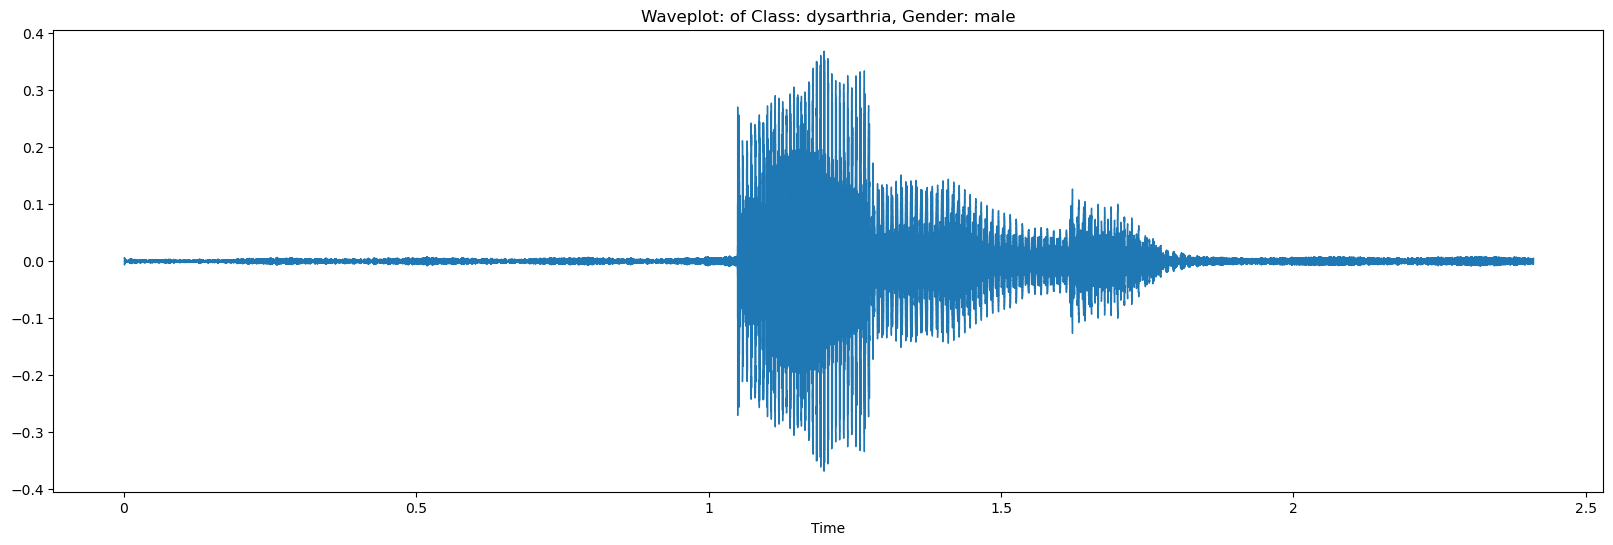

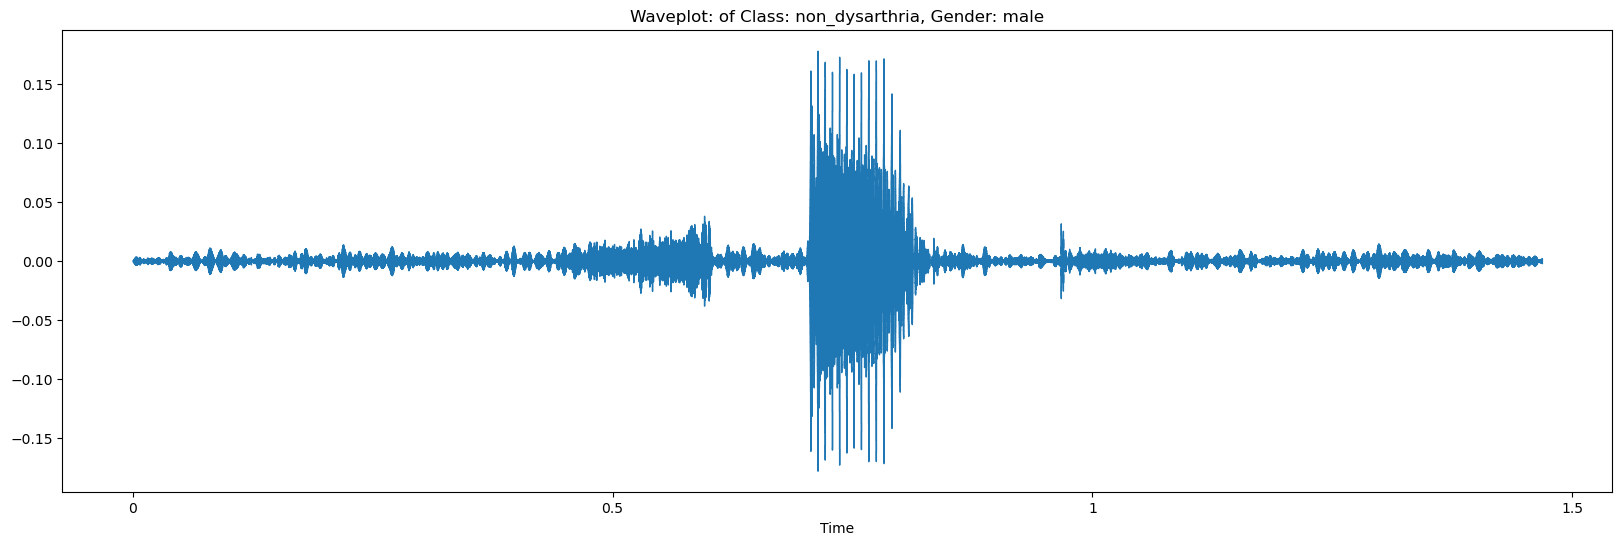

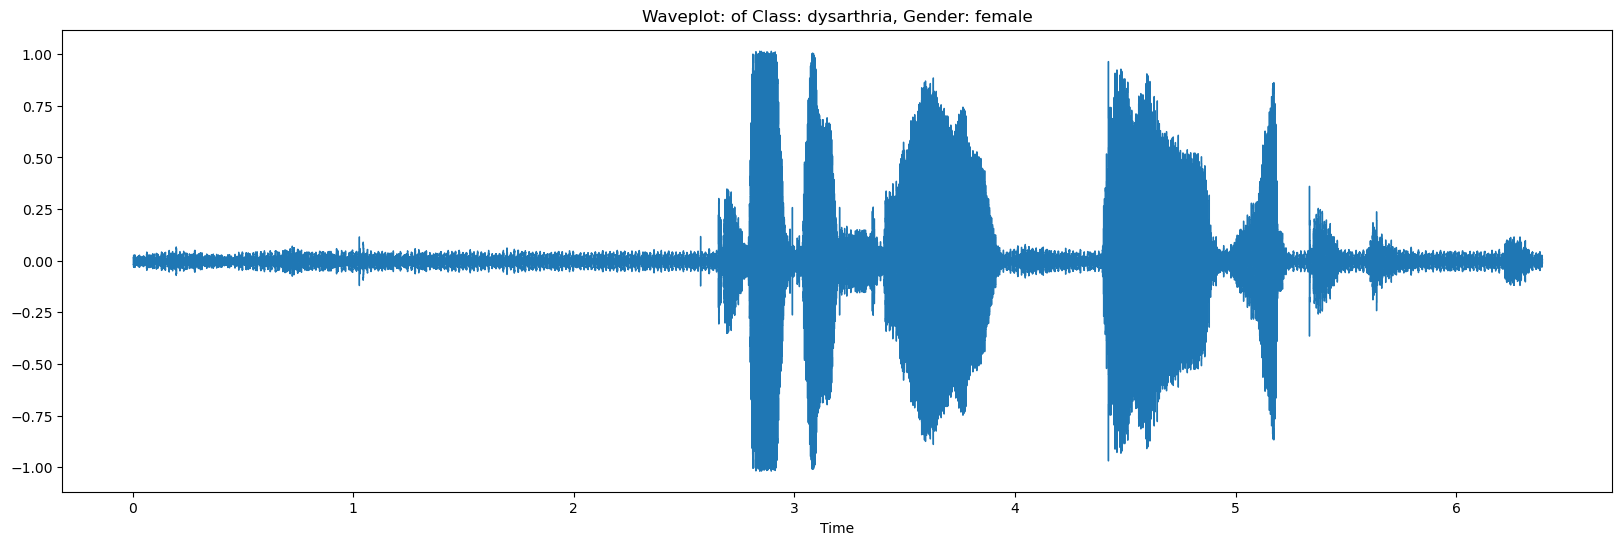

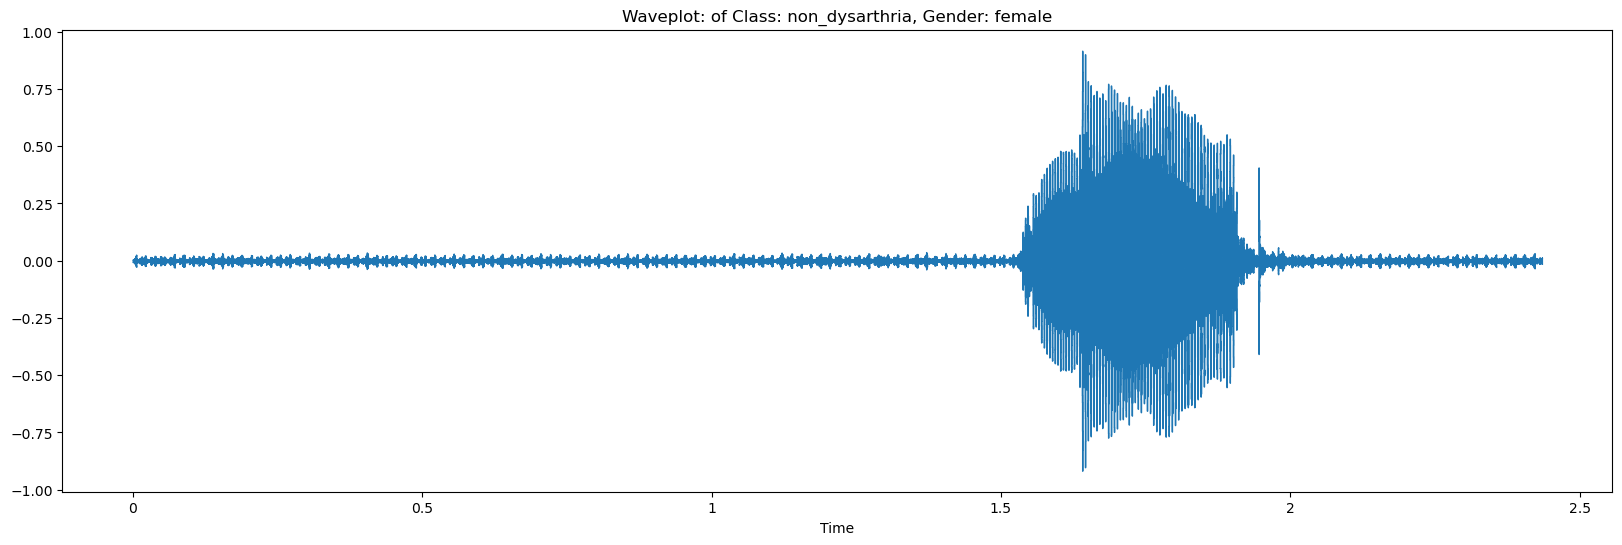

In [12]:
show_waveplot(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_waveplot(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)

show_waveplot(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_waveplot(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

The sound waveform analysis shows the frequency of the detected sound at a certain time range. It can be seen that the frequencies of the sound waves of men and women identified with dysarthria have shorter sound wavelengths than those of men and women who are not identified with dysarthria.

### Explore Chracteristic of Target Dysarthria Based on Spectogram

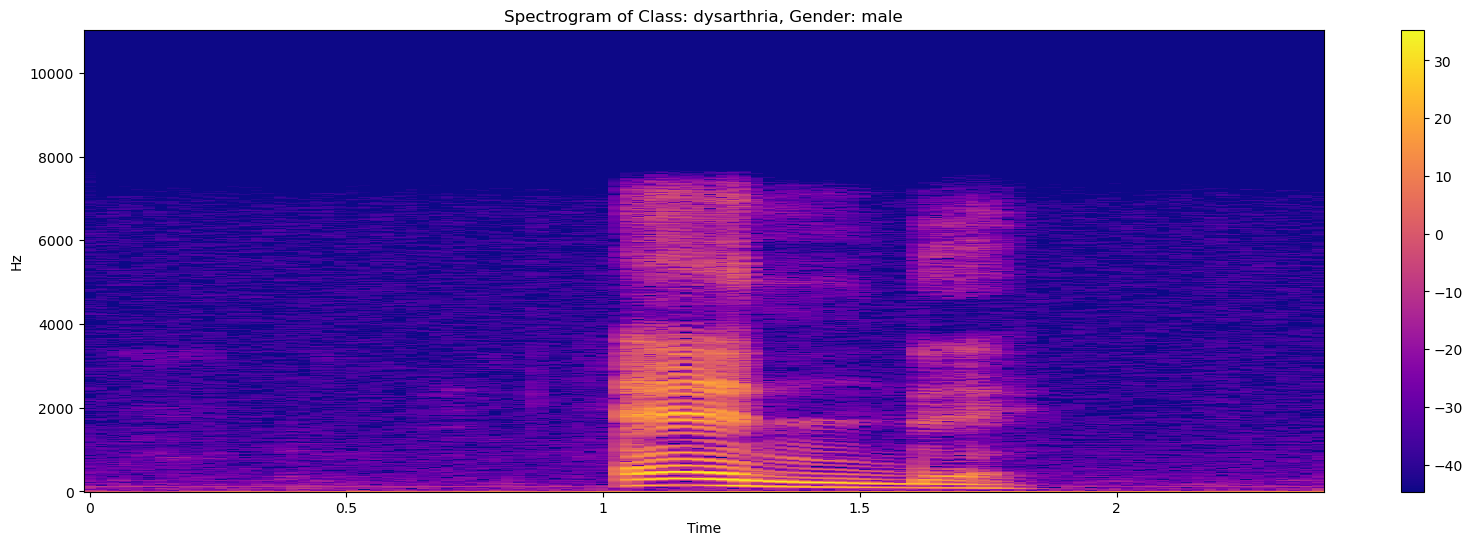

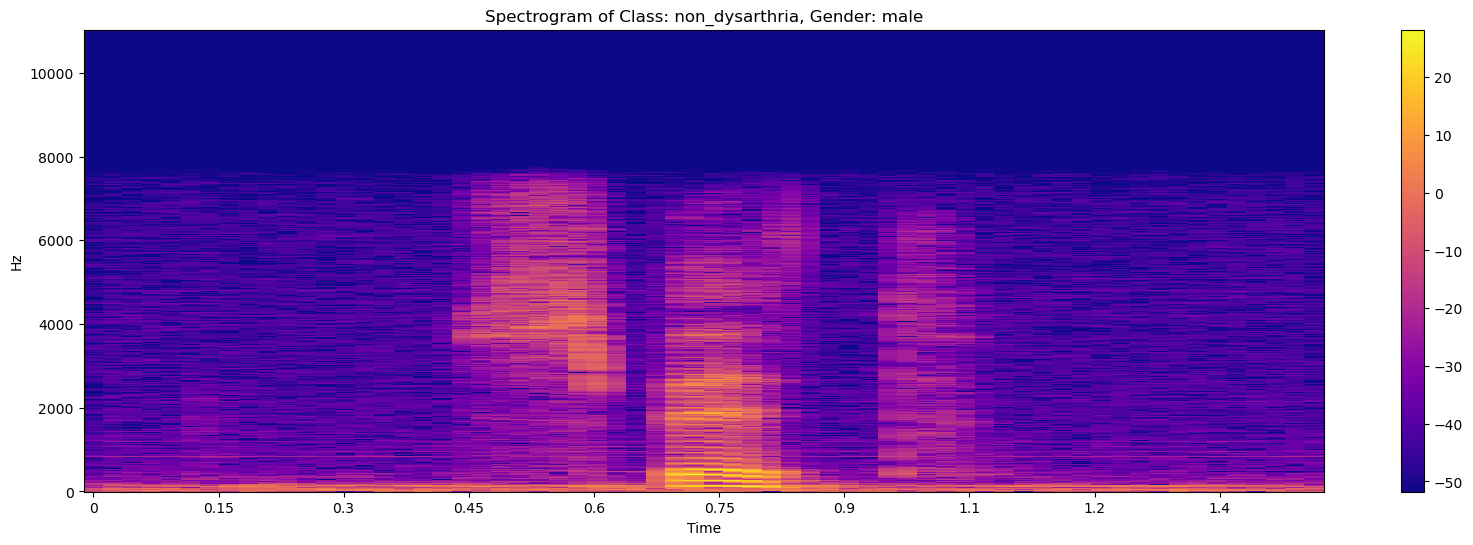

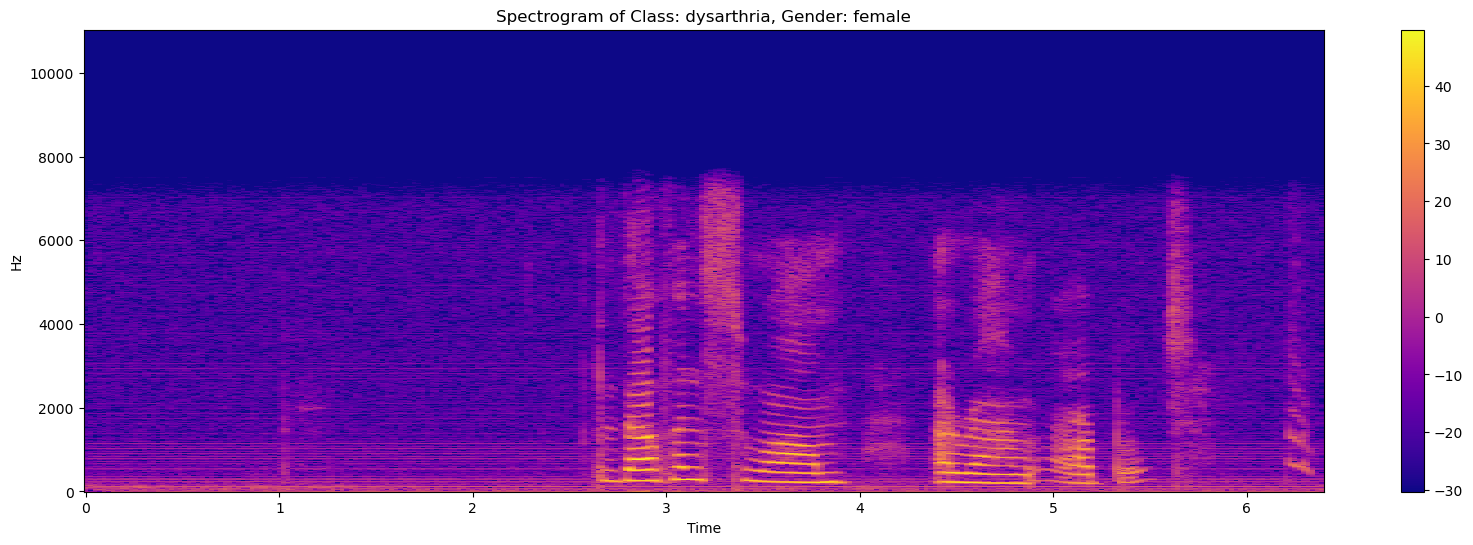

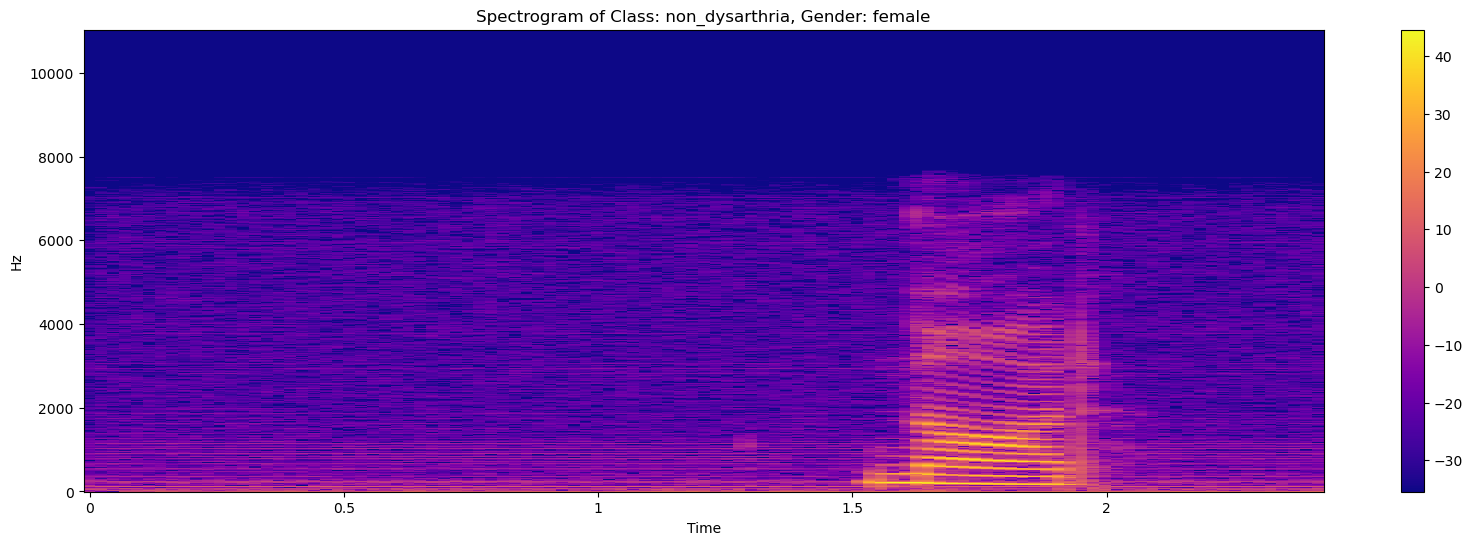

In [13]:
show_spectrogram(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectrogram(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_spectrogram(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_spectrogram(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

In the spectrograms displayed for each sample, the time-frequency localization is different. For men identified with Dysarthria, the time-frequency localization is below 2 seconds, for women indicated the time-frequency localization is below 1 second. While for healthy men and women it is in the range of above 1-2 seconds.

### Explore Chracteristic of Target Dysarthria Based on Zero Cross Rate

Sum of zero crossing  1161


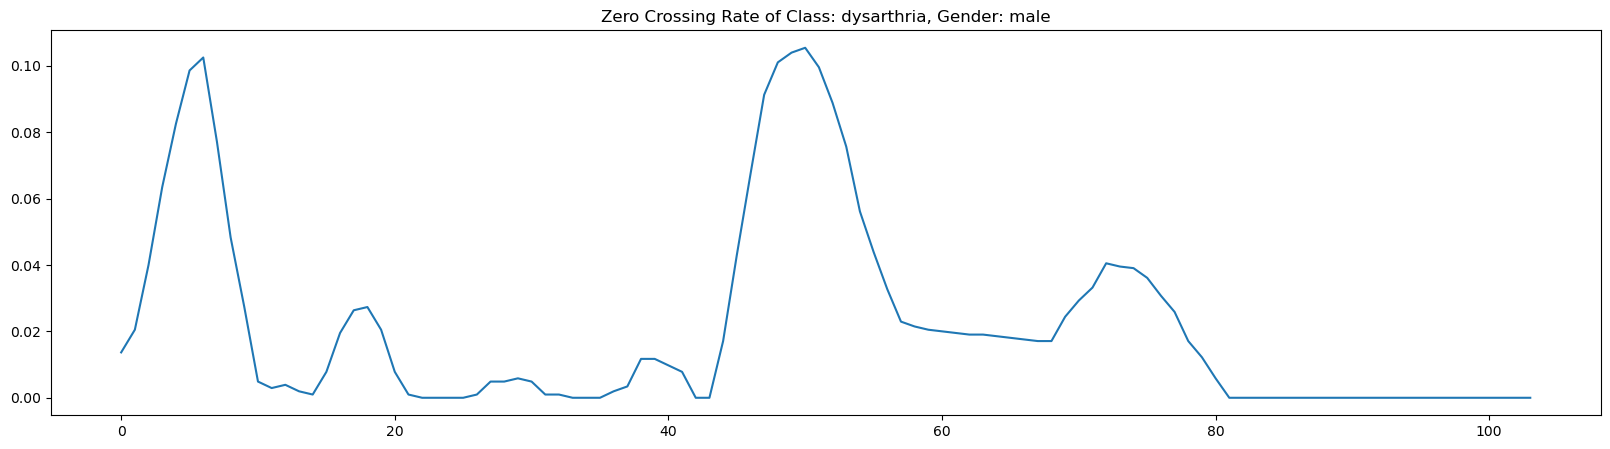

Sum of zero crossing  1846


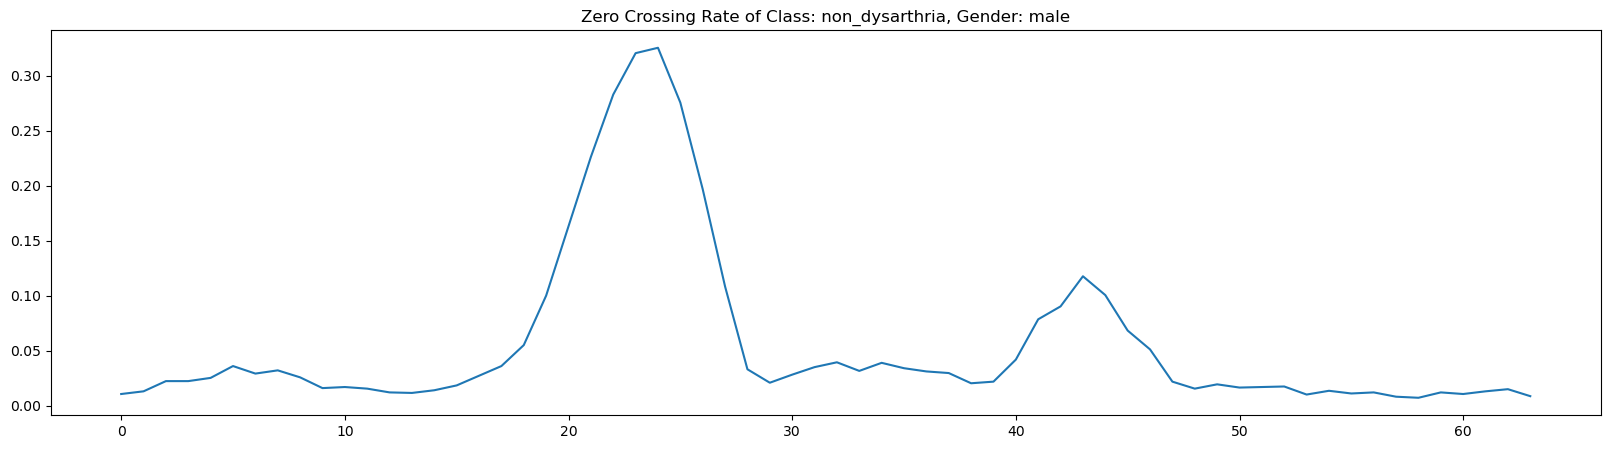

Sum of zero crossing  11511


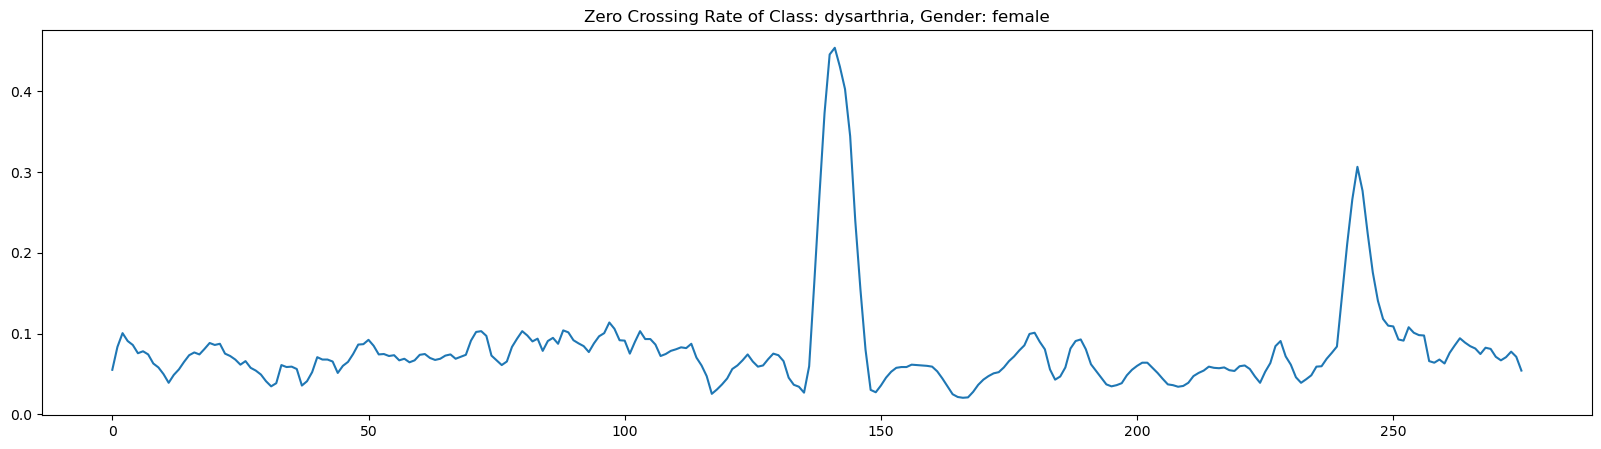

Sum of zero crossing  3679


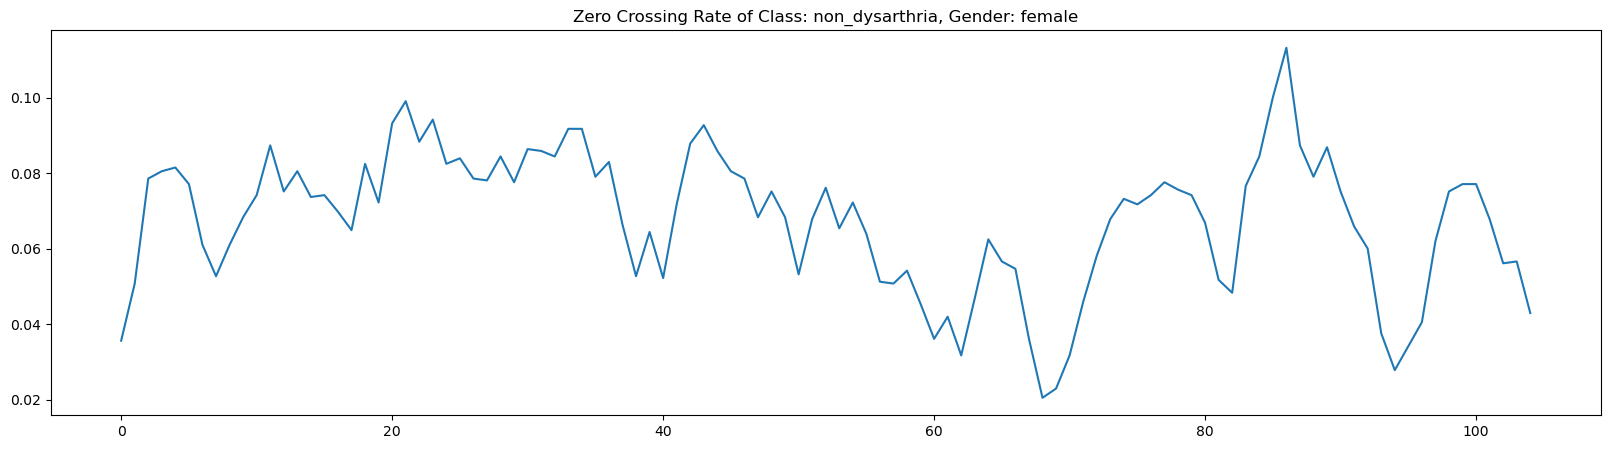

In [14]:
show_zcr(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_zcr(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_zcr(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_zcr(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

Zero Crossing Rate (ZCR) visualization can provide insights into the basic properties of an audio signal. It can give an indication of the degree of harshness or smoothness of the sound in the audio signal. In this audio sample, the male with identified dysarthria has a total ZCR of 2603 (41%) which is softer than the male without identified dysarthria with a ZCR score of 6346. While for female samples with dysarthria identification have a total ZCR score of 1990 (45%) softer than women who are not identified with dysarthria with a ZCR Score of 4373.

### Explore Chracteristic of Target Dysarthria Based on Spectral Centroids

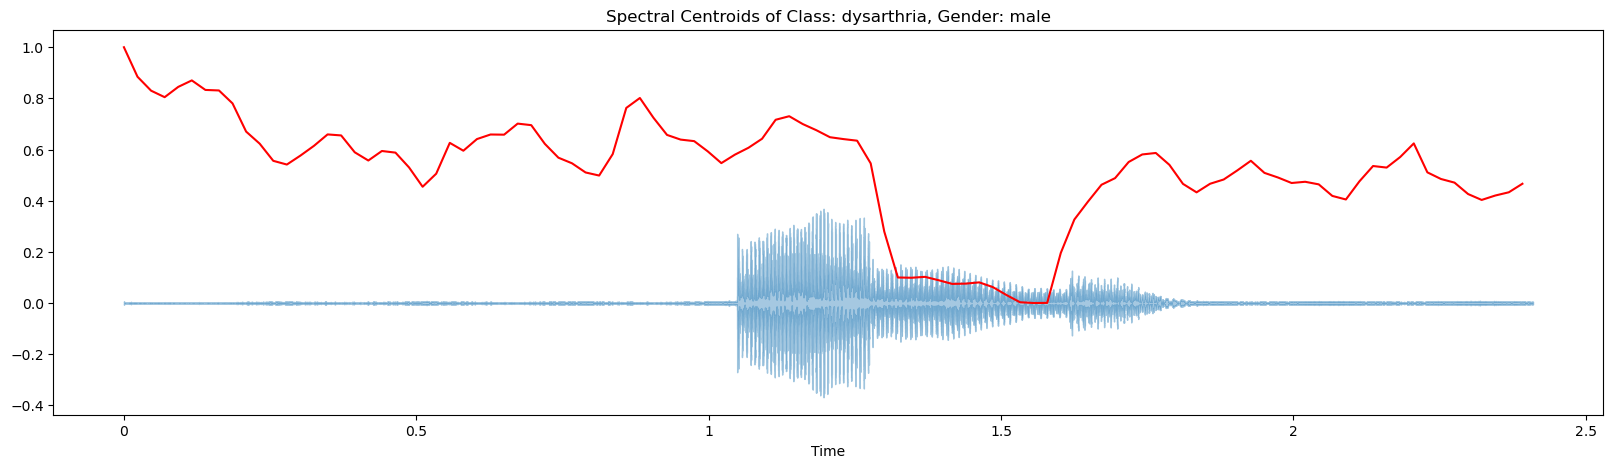

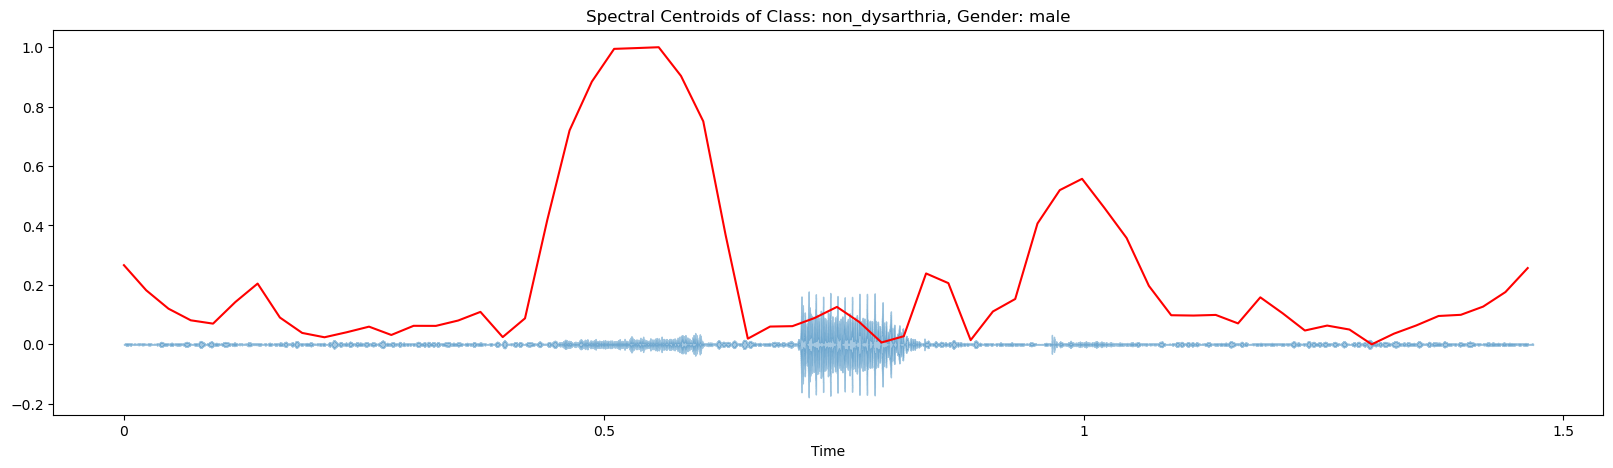

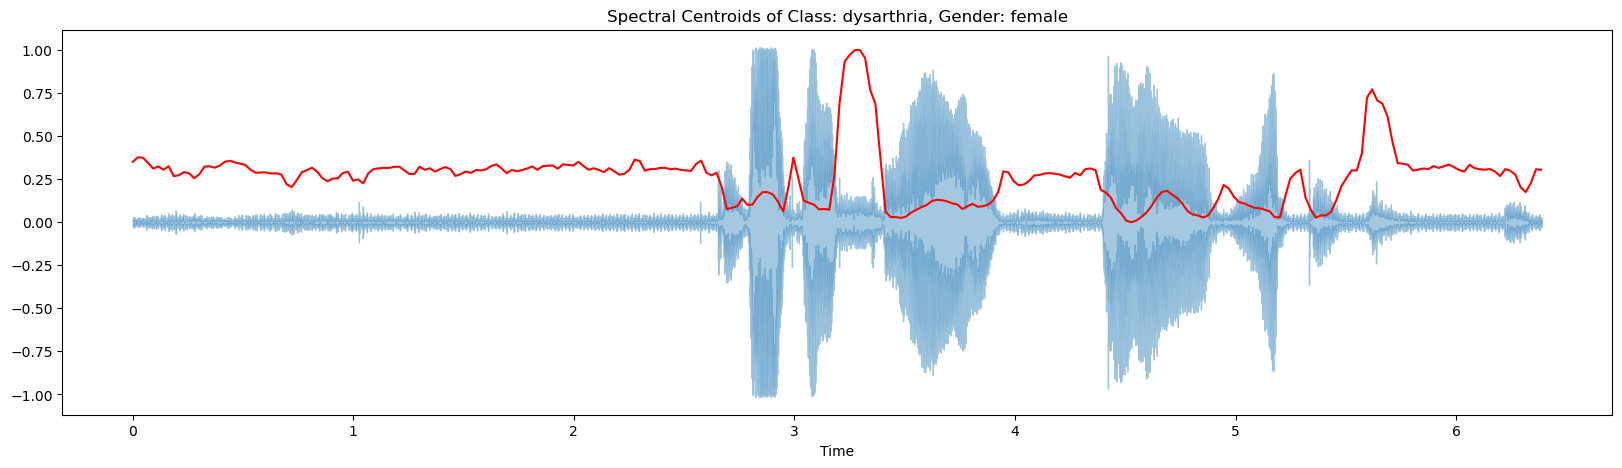

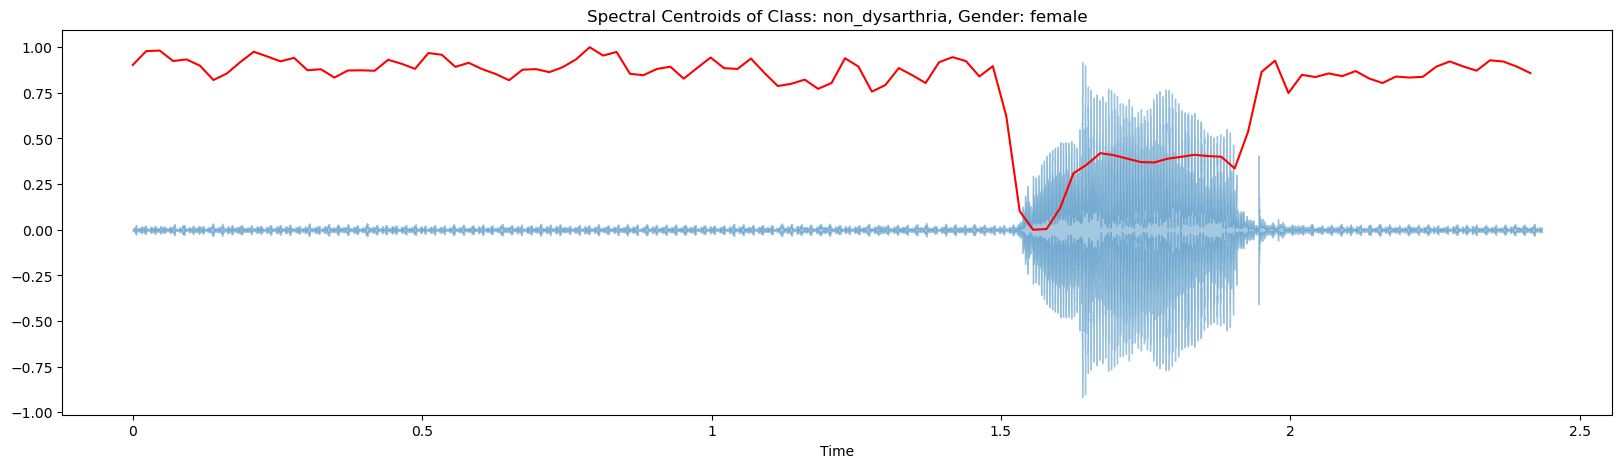

In [15]:
show_spectral_centroids(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectral_centroids(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_spectral_centroids(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_spectral_centroids(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

### Explore Chracteristic of Target Dysarthria Based on Spectral Centroids Rolloff

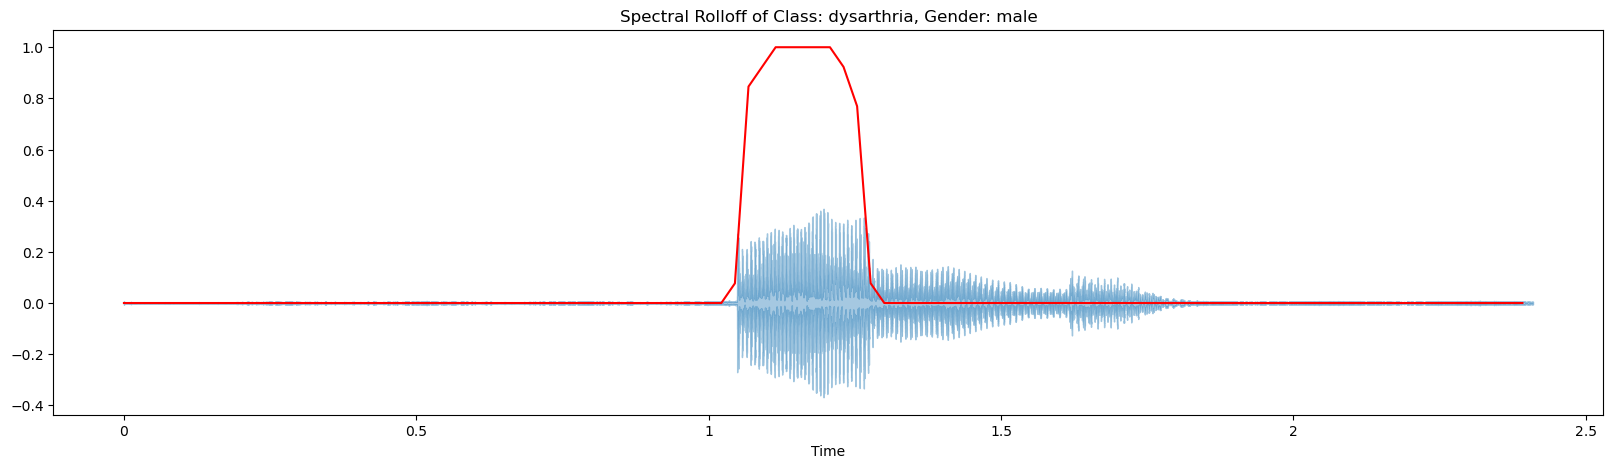

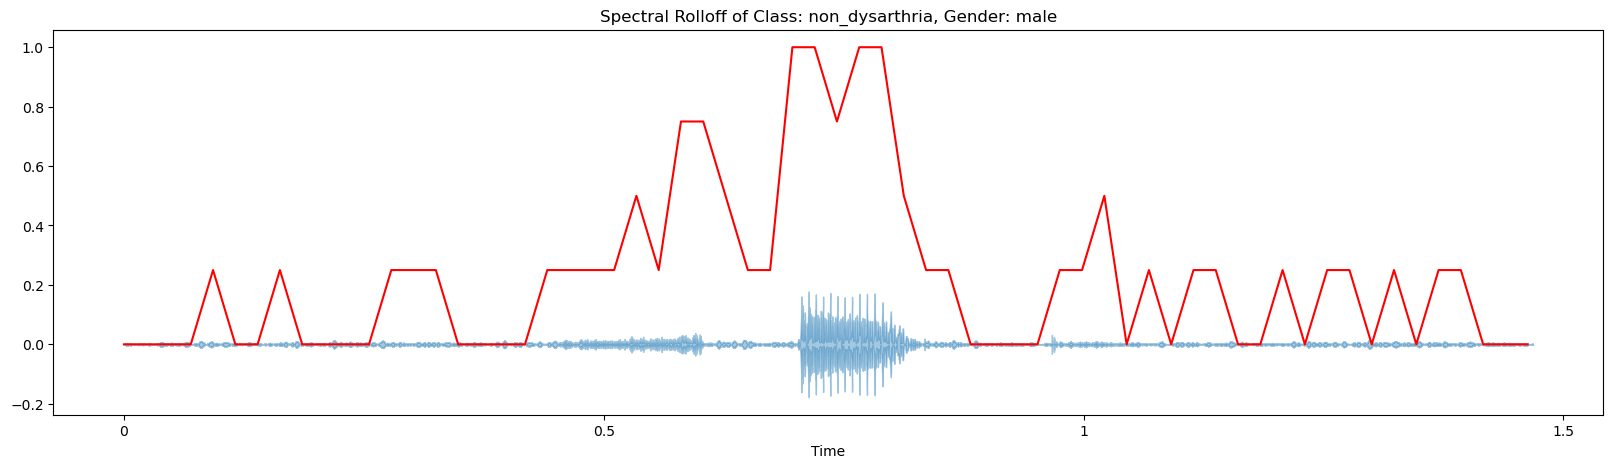

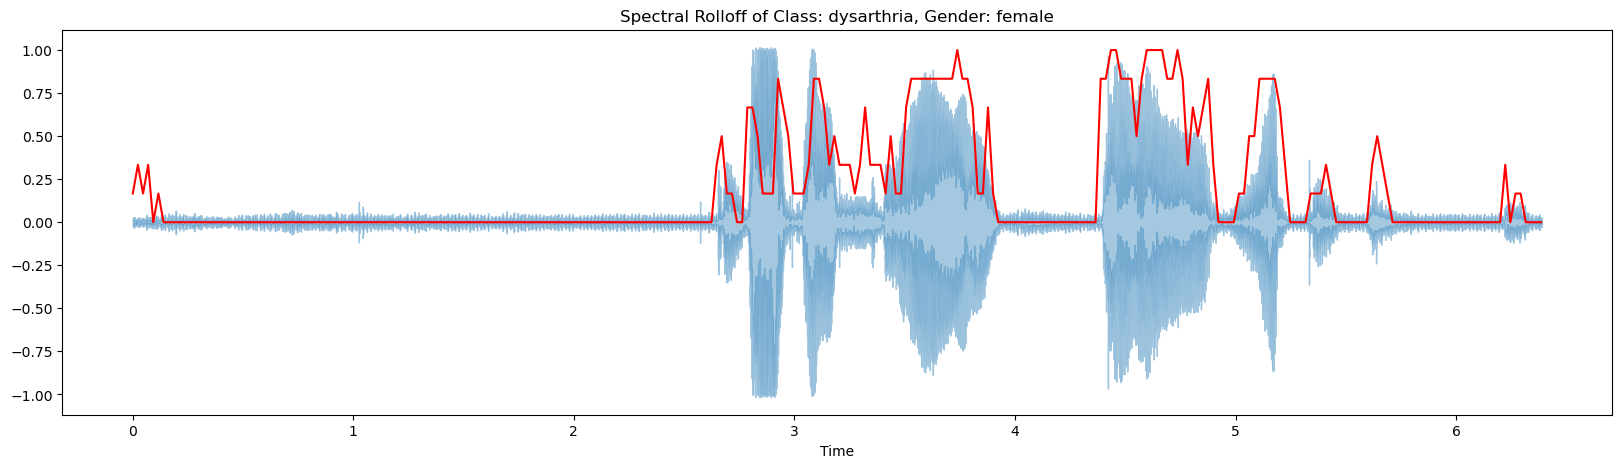

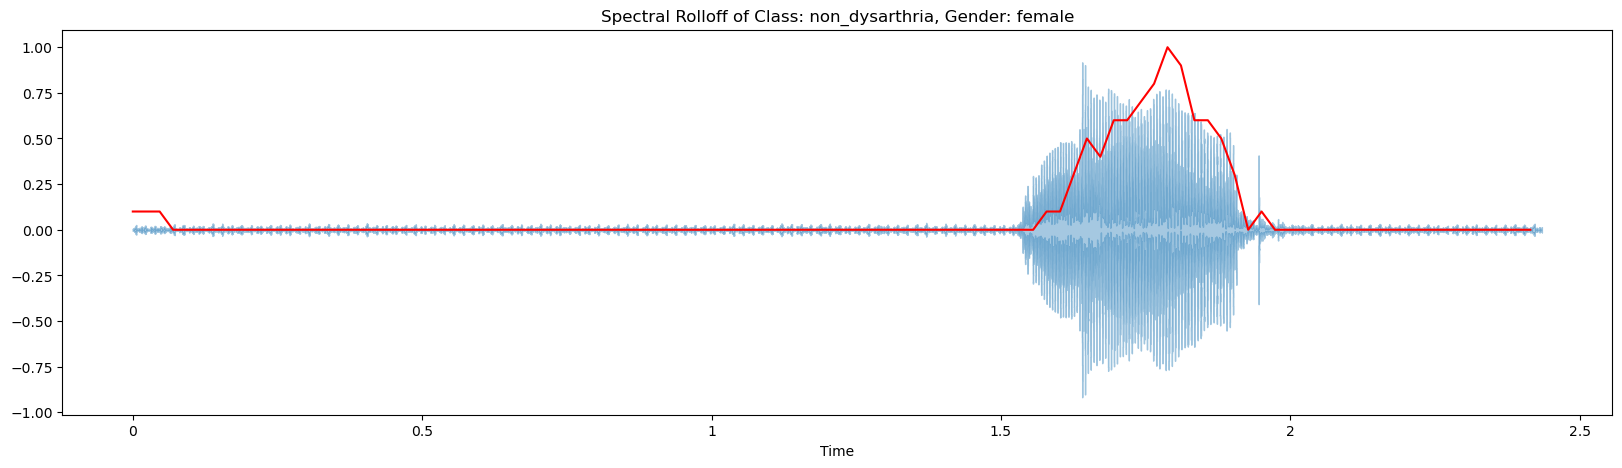

In [16]:
show_spectral_rolloff(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectral_rolloff(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_spectral_rolloff(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_spectral_rolloff(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

# Feature Extraction

In [17]:
def feature_extraction(df):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['filename'])
            mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)
            features.append(mean_mfcc)
        except EOFError:
            pass
        
    dataf = pd.DataFrame(features)
    dataf['class'] = df['is_dysarthria']
    return dataf

In [18]:
dataf = feature_extraction(data)
dataf

  0%|          | 6/2000 [00:00<00:39, 50.53it/s]

100%|██████████| 2000/2000 [00:24<00:00, 80.09it/s] 


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,class
0,-221.788269,101.259232,-16.548128,38.492065,-13.595651,20.772558,-5.536352,10.410690,1.962460,-0.799047,...,0.962194,0.744855,1.058081,0.388451,0.081759,0.546172,0.594358,0.170033,-0.219215,non_dysarthria
1,-299.520081,109.872574,-17.097265,38.854965,-16.881124,22.959129,1.824228,18.724188,3.448539,4.455823,...,1.105590,1.056283,1.252576,0.027334,-1.368949,-0.037860,0.020663,-0.082126,-0.744831,non_dysarthria
2,-302.950043,112.048485,-23.679876,44.887421,-22.434723,26.299335,0.811477,18.210289,4.344696,4.912156,...,0.844332,0.530005,1.018391,0.055385,-1.472087,0.295324,0.191228,-0.224301,-0.582725,non_dysarthria
3,-210.861603,116.504486,-35.046494,37.670425,-27.112514,25.593725,-7.511986,13.140748,-0.587346,4.138087,...,0.630752,0.898457,0.721398,0.174576,-0.090706,0.001524,0.360464,-0.075448,-0.259716,non_dysarthria
4,-280.227203,104.505051,-17.209881,45.064888,-15.542126,28.115068,-3.449212,16.841440,4.573239,1.738296,...,1.596206,0.970084,0.732017,0.547591,-0.152662,0.131891,-0.288228,-0.468571,-0.461725,non_dysarthria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-304.231995,115.359306,-0.794744,26.543356,-0.682189,13.183385,2.389221,4.290236,-1.372814,-2.624717,...,0.473924,0.103740,0.311735,0.015567,-0.055351,0.193022,0.332826,0.014454,-0.221992,dysarthria
1995,-457.822144,110.087807,22.221979,-0.056083,-11.181313,3.190079,-4.499058,4.474750,5.809543,-1.913340,...,0.622935,0.508346,0.398741,0.455835,0.348570,0.286895,0.150863,-0.053001,0.001198,dysarthria
1996,-371.546875,116.846909,5.667275,22.488144,8.221017,7.740129,8.989120,9.996634,4.383991,3.590931,...,0.240279,-0.009781,-0.018250,-0.014396,-0.263360,0.556258,0.749679,-0.283884,-0.398583,dysarthria
1997,-302.500702,112.511192,-4.506536,32.498363,-1.519382,4.109809,4.611471,9.744306,-2.962908,-3.497744,...,0.146675,-0.200982,0.388718,0.160435,-0.383473,0.417756,1.042827,-0.082763,-0.111990,dysarthria


# Feature Selection

In [19]:
#Change the Target as Binner class.
dataf.loc[dataf['class']=='non_dysarthria','class'] = 0.0
dataf.loc[dataf['class']=='dysarthria','class'] = 1.0
dataf['class'] = dataf['class'].astype(float)

X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1]

In [20]:
X.shape, y.shape

((1999, 128), (1999,))

## Split The Feature

In [21]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=55)
X_train, X_validation, y_train, y_validation = train_test_split(X_temp, y_temp, test_size=0.10, random_state=55)
#Adding Dimentional for CNN
X_train = X_train.reshape(-1,16,8,1)
X_test = X_test.reshape(-1,16,8,1)
X_validation = X_validation.reshape(-1,16,8,1)

In [22]:
X_train.shape

(1529, 16, 8, 1)

# Model Train

In this project, two methods, namely Random Forest and Assemble CNN, are used to build training models on audio datasets. The selection of these two models is based on several reasons: Random Forest can be used to handle the complexity and diversity of audio datasets, while CNN can be used to capture spatial patterns and extract features automatically.

## Random Forest

In [23]:
#Random Forests

from sklearn.ensemble import RandomForestClassifier

# Split data into train and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.15, random_state=42)

# Train Random Forest model 
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions
y_pred = rf_model.predict(X_test_rf)

# Evaluate model
print(confusion_matrix(y_test_rf, y_pred))
print(classification_report(y_test_rf, y_pred))

[[157   1]
 [  3 139]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       158
         1.0       0.99      0.98      0.99       142

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



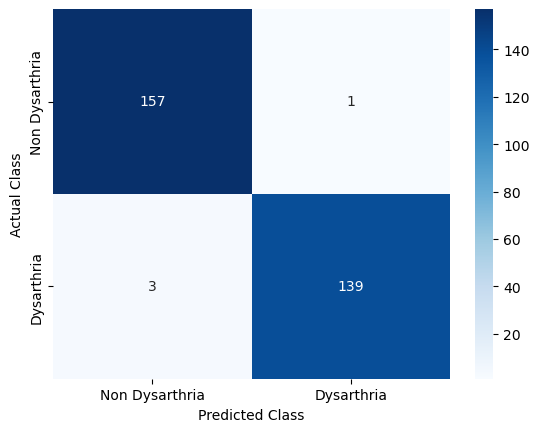

In [24]:
sns.heatmap(confusion_matrix(y_test_rf, y_pred),cmap='Blues',fmt='g',annot=True,
            xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

## CNN (Convolutional Neural Network)

In [25]:
# Resize the input images to match the original AlexNet input size (55x55)
model = Sequential([
    InputLayer(input_shape=(16, 8, 1)),
    Resizing(55, 55),  # Resize the input to 55x55
    
    # Convolutional Layer 1
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding="valid"),
    
    # MaxPooling Layer 1
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Resize the output of MaxPooling Layer 1 to 27x27
    Resizing(27, 27),
    
    # Convolutional Layer 2
    Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding="same"),
    
    # MaxPooling Layer 2
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Convolutional Layer 3
    Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding="same"),
    
    # Convolutional Layer 4
    Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding="same"),
    
    # Convolutional Layer 5
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding="same"),
    
    # MaxPooling Layer 3
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    Flatten(),
    
    # Fully Connected Layer 1
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Fully Connected Layer 2
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Output Layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 55, 55, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 12, 12, 96)     │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,262,209 (222.25 MB)

 Trainable params: 58,262,209 (222.25 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)


In [28]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_validation,y_validation), callbacks=[checkpoint,earlystopping])

Epoch 1/50


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5449 - loss: 5.3643
Epoch 1: val_loss improved from inf to 0.55887, saving model to model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5459 - loss: 5.2962 - val_accuracy: 0.7412 - val_loss: 0.5589
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7005 - loss: 0.5944
Epoch 2: val_loss improved from 0.55887 to 0.48583, saving model to model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7006 - loss: 0.5944 - val_accuracy: 0.7706 - val_loss: 0.4858
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7750 - loss: 0.4921
Epoch 3: val_loss improved from 0.48583 to 0.43305, saving model to model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7751 - loss: 0.4919 - val_accuracy: 0.8118 - val_loss: 0.4331
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7850 - loss: 0.4762
Epoch 4: val_loss improved from 0.43305 to 0.37861, saving model to model.keras
48/48 ━━━━━━━━━━━

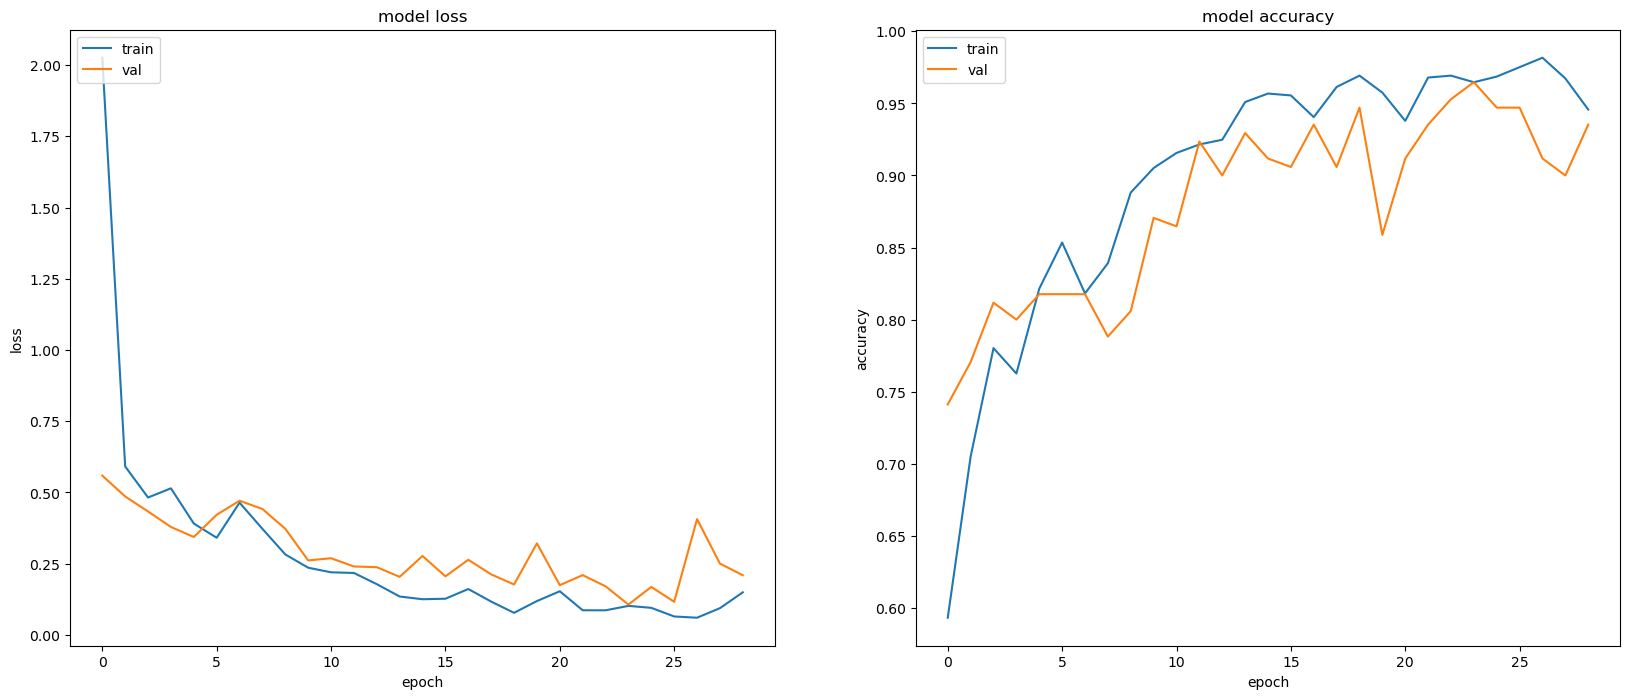

In [29]:
fig, ax = plt.subplots(ncols=2,figsize=(20,8))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')
#ax[0].set_ylim(0,0.01)

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
#ax[1].set_ylim(0.5,1.5)

plt.show()

The two lines represent the loss incurred by the model during training (training loss) and its performance on a separate validation dataset (validation loss).

In this case, the closely following training and validation loss curves suggest a good fit. This indicates that the model is effectively learning from the training data and generalizes well to unseen data (validation set).

In [30]:
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step


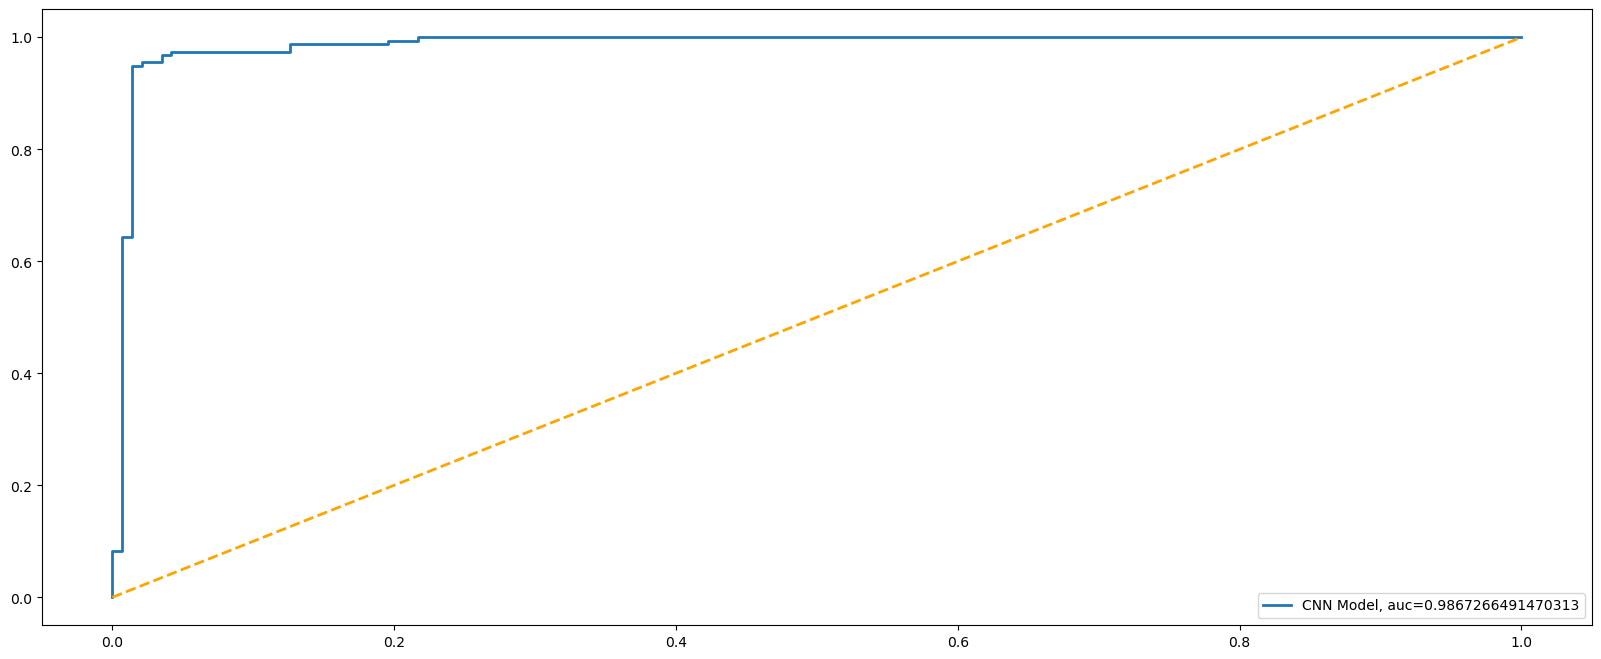

In [31]:
plt.figure(figsize=(20,8))
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="CNN Model, auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [32]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

In [33]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))


[[136   7]
 [  4 153]]
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       143
         1.0       0.96      0.97      0.97       157

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



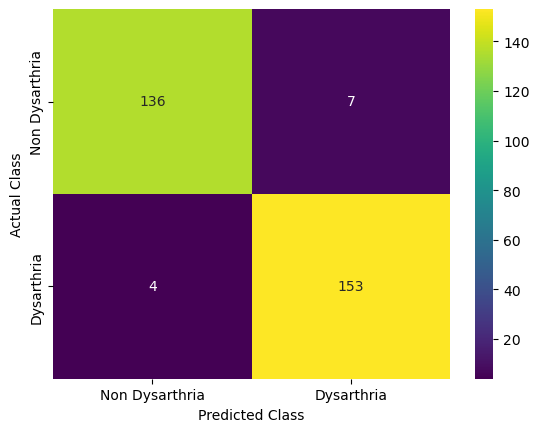

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.3g',
            xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

# Model Saving

## Random Forest Saving

In [35]:
import pickle
# Saving ML Model
with open('rf_model.pkl', 'wb') as file_1:          
  pickle.dump(rf_model,file_1)

## CNN Saving

In [36]:
# Saving CNN Model
model.save('my_saved_model.h5')

# Conclutions


In this project, two models, Random Forest and Assemble CNN, were used to build training models on audio datasets. It was found that Random Forest achieved an accuracy score of 99%, while CNN achieved an accuracy score of 96%. This significant difference in performance can be explained by several factors:

## Audio Dataset Characteristics:

Complexity: Audio datasets often have a high level of complexity, with a high variety of sounds and noise. This can make it difficult for CNNs to capture relevant patterns and produce accurate predictions.
Spatial Structure: CNNs are designed to capture spatial patterns in data. However, audio datasets may not have a clear spatial structure, so CNNs may not be able to utilize their power to the fullest.
Dataset Size: CNN performance generally improves as the dataset size increases. In this project, the audio dataset used may not be large enough to allow the CNN to achieve optimal performance.
Power of Random Forest Model:

Handling Complexity: Random Forest is more reliable in handling complex and unstructured data, such as audio datasets. Its ability to build multiple decision trees allows the model to better capture variation and noise in the data.
Interpretation: Random Forest models are relatively easy to interpret, allowing us to understand the factors that influence the model's predictions. This can help in identifying potential problems in the dataset or model.

This significant performance difference between Random Forest and CNN on audio datasets is likely due to the characteristics of audio datasets and the strength of the Random Forest model in handling complex data. Random Forest may be more suitable for complex and unstructured audio datasets, while CNN may be more suitable for audio datasets with clear spatial structure and large dataset size.

## Suggestion:

- CNN Model Adjustment: Trying different CNN architectures or adding data augmentation techniques to increase the dataset size.
- Further Investigation: Conduct further analysis on the audio dataset to better understand its characteristics and identify potential issues that may affect CNN performance.
- Ensemble Learning: Considered the use of ensemble learning, where predictions from both models are combined to produce a more accurate final prediction.

By making further adjustments and investigations, it is hoped that the performance of CNN on audio datasets can be improved and approach the performance of Random Forest.